# Hyperparameter Tuning

This notebook performs hyperparameter optimisation on the top three baseline models identified in the model selection notebook: Gradient Boosting, Random Forest, and XGBoost. RandomizedSearchCV is used to explore a broad hyperparameter space with 5-fold cross-validation.


## 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator
from xgboost import XGBRegressor
from typing import Dict, Any

## 2. Data Loading and Preprocessing

Load the training data and apply initial filtering to remove invalid entries.

In [2]:
df = pd.read_csv("../data/CW1_train.csv")
# Remove physically impossible dimensions identified in the EDA
df = df[(df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0) & (df["y"] <= 10)]

## 3. Pipeline and Search Setup

Import the shared pipeline builder and configure cross-validation and hyperparameter search spaces.

In [3]:
from pathlib import Path
import sys

current_directory = Path().resolve()
if current_directory.name == "notebooks":
    project_root = current_directory.parent
elif (current_directory / "src").exists():
    project_root = current_directory
else:
    project_root = current_directory.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.pipeline import build_pipeline

Separate features and target variable.

In [4]:
X = df.drop(columns=["outcome"])
Y = df["outcome"]

Use 5-fold cross-validation consistent with the baseline evaluation.

In [5]:
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)

Define hyperparameter search spaces for each model.

In [6]:
random_forest_parameters = {
    "model__n_estimators": [200, 400, 600, 800],  
    "model__max_depth": [None, 8, 12, 16, 20],          
    "model__min_samples_split": [2, 4, 6, 8, 10],      
    "model__min_samples_leaf": [1, 2, 4, 6],           
    "model__max_features": ["sqrt", "log2", 0.8, None],
    "model__bootstrap": [True, False]               
}


gradient_boosting_parameters = {
    "model__n_estimators": [200, 400, 600, 800, 1000],
    "model__max_depth": [3, 4, 5, 6, 8],             
    "model__learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],  
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_samples_split": [2, 5, 10],           
    "model__min_samples_leaf": [1, 2, 4]          
}

extreme_gradient_boosting_parameters = {
    "model__n_estimators": [400, 600, 800, 1000, 1200],  
    "model__max_depth": [3, 4, 5, 6, 7],                 
    "model__learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "model__min_child_weight": [1, 3, 5, 7, 10],        
    "model__gamma": [0, 0.1, 0.2, 0.3, 0.5],            
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],      
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__reg_alpha": [0, 0.01, 0.1, 0.5, 1],         
    "model__reg_lambda": [1, 1.5, 2, 3, 5],             
}


Define the random search helper and models to tune.

In [ ]:
def random_search(model: BaseEstimator, parameters: Dict[str, Any], name: str):
    pipeline = build_pipeline(model)
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=50,
        cv=cross_validation,
        scoring="r2",
        n_jobs=-1,
        verbose=1,
        refit=True,
        random_state=42
    )
    search.fit(X, Y)
    
    print(f"{name} Random Search Best R²: {search.best_score_:.4f}")
    print(f"{name} Best Params: {search.best_params_}")
    
    return search

In [ ]:
models_to_tune = {
    "Random Forest": (
        RandomForestRegressor(random_state=42, n_jobs=-1), random_forest_parameters
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=42), gradient_boosting_parameters
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0, n_jobs=-1, eval_metric="rmse"), extreme_gradient_boosting_parameters
    ),
}

Run RandomizedSearchCV for each model.

In [9]:
tuning_results = {}

for name, (model, parameters) in models_to_tune.items():
    print(f"Tuning: {name}")
    search_result = random_search(model, parameters, name)
    tuning_results[name] = search_result


Tuning: Random Forest
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest Random Search Best R²: 0.4600
Random Forest Best Params: {'model__n_estimators': 800, 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__max_features': 0.8, 'model__max_depth': 20, 'model__bootstrap': True}
Tuning: Gradient Boosting
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Gradient Boosting Random Search Best R²: 0.4722
Gradient Boosting Best Params: {'model__subsample': 1.0, 'model__n_estimators': 400, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 3, 'model__learning_rate': 0.03}
Tuning: XGBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost Random Search Best R²: 0.4742
XGBoost Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 1, 'model__reg_alpha': 0.5, 'model__n_estimators': 800, 'model__min_child_weight': 10, 'model__max_depth': 4, 'model__learning_rate': 0.01, 'model__gamma': 0

### Results Summary

Display the results sorted by mean R² score.

In [10]:
final_results = pd.DataFrame([
    {
        "Model": name,
        "R²": result.best_score_,
        "Std R²": result.cv_results_["std_test_score"][result.best_index_],
        "Best Parameters": result.best_params_
    }
    for name, result in tuning_results.items()
]).sort_values("R²", ascending=False)

final_results


,Model,R²,Std R²,Best Parameters
2,XGBoost,0.474243,0.020947,"{'model__subsample': 0.7, 'model__reg_lambda':..."
1,Gradient Boosting,0.472231,0.020298,"{'model__subsample': 1.0, 'model__n_estimators..."
0,Random Forest,0.459969,0.020491,"{'model__n_estimators': 800, 'model__min_sampl..."


### Visualization

Create a horizontal bar chart comparing tuned model performance.

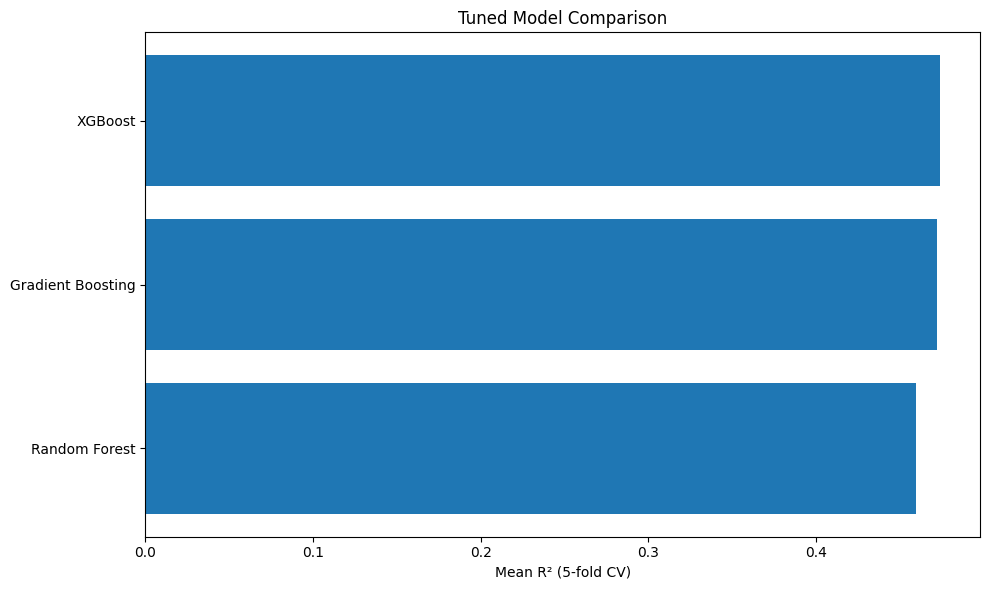

In [11]:
plt.figure(figsize=(10,6))
plt.barh(final_results["Model"], final_results["R²"])
plt.xlabel("Mean R² (5-fold CV)")
plt.title("Tuned Model Comparison")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../figures/final_tuned_models.png", dpi=300)
plt.show()

## 4. Best Model

Summarise the best model and its parameters.

In [12]:
best_model_name = final_results.iloc[0]["Model"]
best_model_parameters = final_results.iloc[0]["Best Parameters"]
best_model_r2 = final_results.iloc[0]["R²"]

print(f"Best Model: {best_model_name}")
print(f"Cross-Validated R²: {best_model_r2:.6f}")
print(f"Best Parameters:")
for parameter, value in best_model_parameters.items():
    print(f"  {parameter}: {value}")

Best Model: XGBoost
Cross-Validated R²: 0.474243
Best Parameters:
  model__subsample: 0.7
  model__reg_lambda: 1
  model__reg_alpha: 0.5
  model__n_estimators: 800
  model__min_child_weight: 10
  model__max_depth: 4
  model__learning_rate: 0.01
  model__gamma: 0
  model__colsample_bytree: 0.8


In [13]:
final_model = tuning_results[final_results.iloc[0]["Model"]].best_estimator_

## 5. Feature Importance

Extract and visualise feature importances from the best tuned model.

In [14]:
preprocessor = final_model.named_steps["preprocessor"]
model = final_model.named_steps["model"]

feature_names = preprocessor.get_feature_names_out()

importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

importance_df.head(15)

,Feature,Importance
0,num__depth,0.500590
27,num__yz_ratio,0.111917
9,num__b3,0.042364
26,num__xz_ratio,0.040860
7,num__b1,0.030567
2,num__a1,0.027709
5,num__a4,0.018486
4,num__a3,0.016203
29,cat__cut,0.010189
1,num__table,0.009762


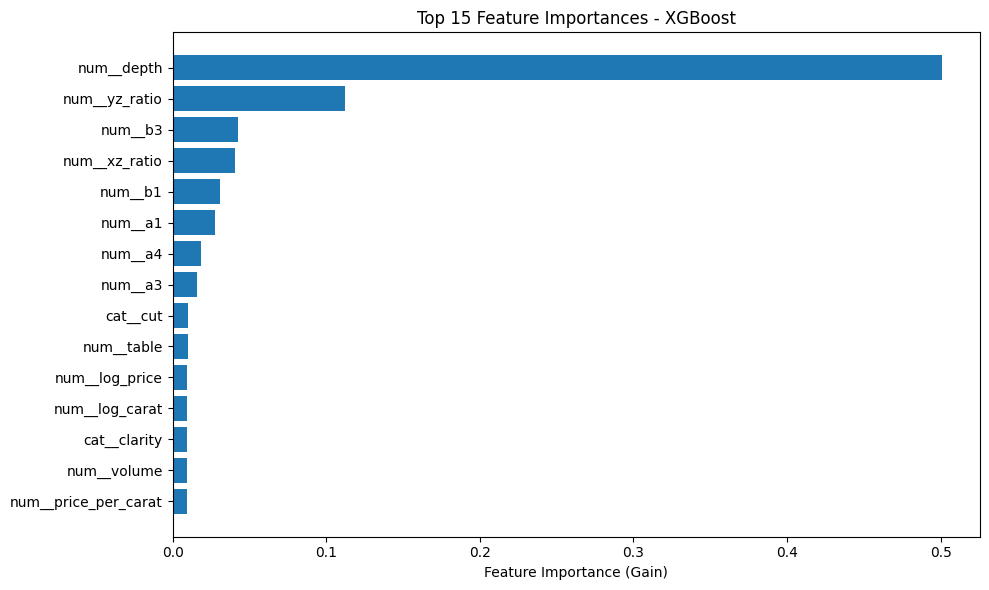

In [15]:
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"][:15][::-1], importance_df["Importance"][:15][::-1])

plt.xlabel("Feature Importance (Gain)")
plt.title("Top 15 Feature Importances - XGBoost")
plt.tight_layout()
plt.savefig("../figures/feature_importance.png", dpi=300)
plt.show()


## 6. Conclusion

XGBoost achieved the highest mean cross-validated R² score following hyperparameter optimisation. Although performance differences between ensemble methods were small, XGBoost was selected as the final model due to its slightly superior performance and regularisation flexibility.

The final model will be retrained on the full training dataset prior to test prediction.
